In [2]:
from __future__ import print_function, division
import numpy as np
import pandas as pd
import math
import pickle
from tqdm import tqdm, tqdm_notebook

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.model_selection import cross_val_score, KFold, train_test_split

from sklearn.metrics import balanced_accuracy_score, roc_auc_score, classification_report, log_loss

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

from imblearn.metrics import classification_report_imbalanced

from sklearn.linear_model import LogisticRegression


import matplotlib as mpl

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")
pd.set_option('display.max_columns', 100)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
def memory(df):
    print("Memory usage of the dataframe is {:.2f} MB".format(
        df.memory_usage().sum() / 1024**2))
    
    
def entropy(df, base = 2):
    """ Calculate the entropy for every column in a df"""
    
    entropy = {}
    
    for column in df.columns:
        prob = df[column].value_counts(normalize=True, sort=False)
        
        entropy[column] = -(prob * np.log(prob)/np.log(base)).sum()
        
    return pd.Series(entropy).sort_values(ascending=False)

# Train LR model

Download pickle resampled data from:
https://liveuclac-my.sharepoint.com/:u:/r/personal/ucabjcv_ucl_ac_uk/Documents/resampled?csf=1&e=swcNPL
*It contains a exsension less file, you might need to remove it if you find troubles using it*

contains tuple(X_resampled, y_resampled)


*alternatively download the trained LR model here:*
https://liveuclac-my.sharepoint.com/:u:/r/personal/ucabjcv_ucl_ac_uk/Documents/lr_model?csf=1&e=5j4WJX

In [3]:
validation = pd.read_hdf('preprocessed.h5', 'validation')
X_resampled, y_resampled = pickle.load(open( "resampled", "rb" ))

y_validate_true = validation['click'].values
X_validate = validation.drop(columns=['click', 'payprice'])

In [53]:
%%time
random_seed = 4448

lr = LogisticRegression(solver='lbfgs', max_iter=500, C=1, n_jobs=-1, random_state=1, class_weight='balanced') 
lr.fit(X_resampled, y_resampled)

# export model
pickle.dump(lr, open( "lr_model", "wb" ))

print('done')

done
CPU times: user 1.97 s, sys: 4.68 s, total: 6.65 s
Wall time: 2min 30s


## Evaluate LR model on validation

In [59]:
y_validate_class = lr.predict(X_validate)
print(classification_report_imbalanced(y_validate_true, y_validate_class, target_names=['no click', 'click']))
print('ROC AUC:\t{:.5f}'.format(roc_auc_score(y_validate_true, y_validate_class)))
print("Log loss:\t{:.5f}".format(log_loss(y_validate_true, y_validate_class)))

y_validate_prob = lr.predict_proba(X_validate)
print('Log loss\t{:.5f}'.format(c, log_loss(y_validate_true, y_validate_prob)))
print('ROC AUC\t{:.5f}'.format(c, roc_auc_score(y_validate_true, y_validate_prob[:,1])))
    
print('done')

                   pre       rec       spe        f1       geo       iba       sup

   no click       1.00      1.00      0.17      1.00      0.42      0.19    303723
      click       0.04      0.17      1.00      0.06      0.42      0.16       202

avg / total       1.00      1.00      0.17      1.00      0.42      0.19    303925

ROC AUC score 0.58508
Balanced accuracy score: 0.58508
done


### Optimize log loss

In [21]:
for c in [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1]:
 
    lr = LogisticRegression(solver='lbfgs', max_iter=500, C=c, n_jobs=-1) 
    lr.fit(X_train, y_train)
    
    y_validate_prob = lr.predict_proba(X_validate)
    print('For C {} Log loss {}'.format(c, log_loss(y_validate_true, y_validate_prob)))
    print('For C {} ROC AUC {}'.format(c, roc_auc_score(y_validate_true, y_validate_prob[:,1])))

For C 1e-05 Log loss 0.6283247722343959
For C 1e-05 ROC AUC 0.677960593196843
For C 0.0001 Log loss 0.47451734312946786
For C 0.0001 ROC AUC 0.7382511171673067
For C 0.001 Log loss 0.2593739151498666
For C 0.001 ROC AUC 0.7823443817994269
For C 0.01 Log loss 0.13113844024481888
For C 0.01 ROC AUC 0.7858815254506754
For C 0.1 Log loss 0.0740039391460614
For C 0.1 ROC AUC 0.7747698992793166
For C 1 Log loss 0.08815361277923775
For C 1 ROC AUC 0.7718528164488597


## Linear bidding strategy pCTR

In [ ]:
%%time
y_validate_prob = lr.predict_proba(X_validate)

payprice = validation['payprice']
clicks = validation['click']

# VERIFY THAT THE pCTR INDEED IS EQUAL TO THE PROB OF CLICK == 1
pCTR_val = y_validate_prob[:, 1]

no_click, click = np.bincount(y_validate_true)
avgCTR = click / (no_click + click)

bid_strategy = lambda base_bid: base_bid * (pCTR_val / avgCTR)

bid_range = np.arange(3.4, 3.8, 0.02)
bid_range_wide = np.arange(1, 5, .5)
bid_range = np.concatenate((bid_range, bid_range_wide), axis=0)

# bid_range = np.arange(1.7, 1.9, 0.01)
statistics = {}

# find optimal base_bid
for base_bid in tqdm(bid_range):
    
    budget_remaining = 6250*1000
    
    statistics[base_bid] = {
        'impressions':0,
        'spend': 0,
        'clicks': 0
    }
    
    # list of bids for all ad requests
    bids = bid_strategy(base_bid)
    
    # loop through all bids for every ad request
    for i in range(len(bids)):    
        second_highest_bid = payprice[i]
        
        won = bids[i] >= second_highest_bid and second_highest_bid <= budget_remaining
        
        if(won):
            statistics[base_bid]['impressions'] += 1
            statistics[base_bid]['spend'] += second_highest_bid
            statistics[base_bid]['clicks'] += clicks[i]
            
            # subtract current bid from budget 
            budget_remaining -= second_highest_bid
            
statistics = pd.DataFrame(statistics).T
statistics['CTR'] = statistics['clicks'] / statistics['impressions']
statistics['aCPM'] = statistics['spend'] / statistics['impressions'] 
statistics['aCPC'] = (statistics['spend']/1000) / statistics['clicks']
print('done')

In [56]:
statistics.sort_values('clicks', ascending=False).head(5)

,clicks,impressions,spend,CTR,aCPM,aCPC
3.52,149,115531,6186524,0.001290,53.548606,41.520295
3.54,149,115967,6216512,0.001285,53.605871,41.721557
3.56,149,116375,6242966,0.001280,53.645250,41.899101
3.60,149,116315,6250000,0.001281,53.733396,41.946309
3.46,148,114269,6101602,0.001295,53.396827,41.227041


In [69]:
lr

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=500,
          multi_class='warn', n_jobs=-1, penalty='l2', random_state=1,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

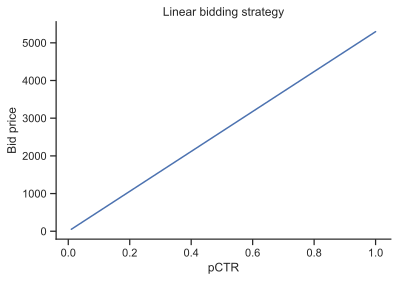

In [18]:
x = np.linspace(1e-2, 1)
no_click, click = np.bincount(y_validate_true)
avgCTR = click / (no_click + click)
y = 3.52 * (x / avgCTR)

plt.plot(x,y)
sns.despine()
plt.title('Linear bidding strategy')
plt.ylabel('Bid price')
plt.xlabel('pCTR')
plt.show()

### Apply linear strategy pCTR to test set

In [28]:
%%time
X_test = test.drop(columns=['click', 'payprice'])
y_test_prob = lr.predict_proba(X_test)
avgCTR = click / (no_click + click)

base_bid = 3.52
pCTR_test = y_test_prob[:, 1]

bid_strategy = lambda base_bid: (base_bid * (pCTR_test / avgCTR))

# get bid id's
test_raw = pd.read_csv('../we_data/test.csv')

# export to file
df_bids = pd.DataFrame(np.round(bid_strategy(base_bid),1), index=test_raw['bidid'].values, columns=['bidprice'])
df_bids.index.name = 'bidid'
df_bids = df_bids.reset_index()

df_bids.to_csv('bid_attemnt.csv', index=False)

CPU times: user 8.48 s, sys: 8.23 s, total: 16.7 s
Wall time: 19.1 s


## ORTB1 bidding

In [58]:
%%time
payprice = validation['payprice']
clicks = validation['click']

y_validate_prob = lr.predict_proba(X_validate)

# VERIFY THAT THE pCTR INDEED IS EQUAL TO THE PROB OF CLICK == 1
pCTR_val = y_validate_prob[:, 1]


ortb_strategy = lambda lamda, const, pCTR: np.sqrt(np.multiply((const / lamda), pCTR) + const**2) - const

lamda_range = np.linspace(1e-6, 1e-4, num=50) #50
const_range = np.arange(10, 100, 5) #5
parameter_grid = [(x,i) for x in const_range for i in lamda_range]

statistics = {}

# find optimal base_bid
for const, lamda in tqdm(parameter_grid):
    budget_remaining = 6250*1000
    
    index = (const, lamda)
    
    statistics[index] = {
        'impressions':0,
        'spend': 0,
        'clicks': 0,
        'too_expensive': 0
    }
    
    # list of bids for all ad requests
    bids = ortb_strategy(lamda, const, pCTR_val)
    
    # loop through all bids for every ad request
    for i in range(len(bids)):    
        second_highest_bid = payprice[i]
        
        won = bids[i] >= second_highest_bid and second_highest_bid <= budget_remaining
        
        if(second_highest_bid > budget_remaining):
            statistics[index]['too_expensive'] += 1
        
        if(won):
            statistics[index]['impressions'] += 1
            statistics[index]['spend'] += second_highest_bid
            statistics[index]['clicks'] += clicks[i]
            
            # subtract current bid from budget 
            budget_remaining -= second_highest_bid
            
    
statistics = pd.DataFrame(statistics).T
statistics['CTR'] = statistics['clicks'] / statistics['impressions']
statistics['aCPM'] = statistics['spend'] / statistics['impressions'] 
statistics['aCPC'] = (statistics['spend']/1000) / statistics['clicks']
print('done')



  0%|          | 0/90 [00:00<?, ?it/s]

  1%|          | 1/90 [00:05<07:26,  5.02s/it]

  2%|▏         | 2/90 [00:09<07:18,  4.98s/it]

  3%|▎         | 3/90 [00:15<07:20,  5.06s/it]

  4%|▍         | 4/90 [00:20<07:14,  5.06s/it]

  6%|▌         | 5/90 [00:24<06:51,  4.84s/it]

  7%|▋         | 6/90 [00:28<06:28,  4.62s/it]

  8%|▊         | 7/90 [00:32<06:08,  4.44s/it]

  9%|▉         | 8/90 [00:36<05:50,  4.28s/it]

 10%|█         | 9/90 [00:40<05:37,  4.16s/it]

 11%|█         | 10/90 [00:44<05:27,  4.10s/it]

 12%|█▏        | 11/90 [00:48<05:28,  4.16s/it]

 13%|█▎        | 12/90 [00:53<05:34,  4.28s/it]

 14%|█▍        | 13/90 [00:57<05:39,  4.40s/it]

 16%|█▌        | 14/90 [01:02<05:40,  4.48s/it]

 17%|█▋        | 15/90 [01:07<05:35,  4.47s/it]

 18%|█▊        | 16/90 [01:11<05:27,  4.43s/it]

 19%|█▉        | 17/90 [01:15<05:18,  4.36s/it]

 20%|██        | 18/90 [01:19<05:08,  4.28s/it]

 21%|██        | 19/90 [01:23<04:58,  4.20s/it]

 22%|██▏       | 20/90 [01:27<04:49,

done
CPU times: user 7min 14s, sys: 9.95 s, total: 7min 24s
Wall time: 7min 34s


In [59]:
statistics.sort_values('clicks', ascending=False).head(20)

,,clicks,impressions,spend,too_expensive,CTR,aCPM,aCPC
40,0.000045,150,127767,6188780,0,0.001174,48.438016,41.258533
60,0.000056,149,123129,6031256,0,0.001210,48.983229,40.478228
70,0.000056,149,125558,6250000,1904,0.001187,49.777792,41.946309
50,0.000056,148,118933,5696792,0,0.001244,47.899170,38.491838
20,0.000034,148,123927,5700968,0,0.001194,46.002631,38.520054
30,0.000045,148,119558,5554669,0,0.001238,46.460036,37.531547
80,0.000067,144,116687,5713091,0,0.001234,48.960818,39.674243
40,0.000056,144,113256,5265855,0,0.001271,46.495153,36.568437
70,0.000067,144,114144,5504208,0,0.001262,48.221615,38.223667
90,0.000067,144,118687,5875892,0,0.001213,49.507461,40.804806


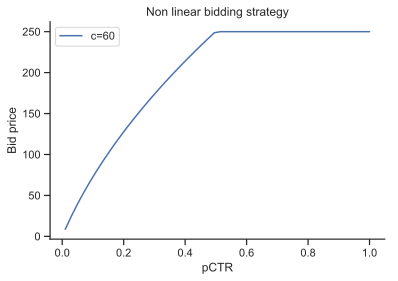

In [83]:
x = np.linspace(1e-2, 1)
y = np.clip(ortb_strategy(0.00056,160,x),0,250)
# y2 = ortb_strategy(0.000056,70,x)
# y3 = ortb_strategy(0.000032,22,x)

plt.plot(x,y, label='c=60')
# plt.plot(x, y2, label='c=70')
# plt.plot(x, y3, label='#3')
sns.despine()
plt.title('Non linear bidding strategy')
plt.ylabel('Bid price')
plt.xlabel('pCTR')
plt.legend()
plt.show()

# ORTB2 bidding

In [66]:
%%time
payprice = validation['payprice']
clicks = validation['click']

# y_validate_prob = lr.predict_proba(X_validate)

# VERIFY THAT THE pCTR INDEED IS EQUAL TO THE PROB OF CLICK == 1
pCTR_val = y_validate_prob[:, 1]

ortb_strategy2 = lambda lamda, const, pCTR: const * (((pCTR+np.sqrt(const**2*lamda**2 + pCTR**2))/(const*lamda))**(1/3)- ((const*lamda)/(pCTR+np.sqrt(const**2*lamda**2 + pCTR**2)))**(1/3))

lamda_range = np.linspace(1e-6, 1e-4, num=30)
const_range = np.arange(10, 100, 20)
parameter_grid = [(x,i) for x in const_range for i in lamda_range]

statistics = {}

# find optimal base_bid
for const, lamda in tqdm(parameter_grid):
    budget_remaining = 6250*1000
    
    index = (const, lamda)
    
    statistics[index] = {
        'impressions':0,
        'spend': 0,
        'clicks': 0,
        'too_expensive': 0
    }
    
    # list of bids for all ad requests
    bids = ortb_strategy2(lamda, const, pCTR_val)
    
    # loop through all bids for every ad request
    for i in range(len(bids)):    
        second_highest_bid = payprice[i]
        
        won = bids[i] >= second_highest_bid and second_highest_bid <= budget_remaining
        
        if(second_highest_bid > budget_remaining):
            statistics[index]['too_expensive'] += 1
        
        
        if(won):
            statistics[index]['impressions'] += 1
            statistics[index]['spend'] += second_highest_bid
            statistics[index]['clicks'] += clicks[i]
            
            # subtract current bid from budget 
            budget_remaining -= second_highest_bid
            
    
statistics = pd.DataFrame(statistics).T
statistics['CTR'] = statistics['clicks'] / statistics['impressions']
statistics['aCPM'] = statistics['spend'] / statistics['impressions'] 
statistics['aCPC'] = (statistics['spend']/1000) / statistics['clicks']
print('done')



  0%|          | 0/150 [00:00<?, ?it/s]

  1%|          | 1/150 [00:06<15:33,  6.27s/it]

  1%|▏         | 2/150 [00:11<14:40,  5.95s/it]

  2%|▏         | 3/150 [00:17<14:42,  6.00s/it]

  3%|▎         | 4/150 [00:22<14:00,  5.75s/it]

  3%|▎         | 5/150 [00:28<13:45,  5.70s/it]

  4%|▍         | 6/150 [00:33<13:17,  5.54s/it]

  5%|▍         | 7/150 [00:38<12:29,  5.24s/it]

  5%|▌         | 8/150 [00:42<11:40,  4.94s/it]

  6%|▌         | 9/150 [00:46<11:09,  4.75s/it]

  7%|▋         | 10/150 [00:50<10:39,  4.57s/it]

  7%|▋         | 11/150 [00:54<10:16,  4.43s/it]

  8%|▊         | 12/150 [00:58<09:57,  4.33s/it]

  9%|▊         | 13/150 [01:02<09:40,  4.24s/it]

  9%|▉         | 14/150 [01:06<09:27,  4.17s/it]

 10%|█         | 15/150 [01:10<09:14,  4.11s/it]

 11%|█         | 16/150 [01:14<09:03,  4.06s/it]

 11%|█▏        | 17/150 [01:18<08:54,  4.02s/it]

 12%|█▏        | 18/150 [01:23<09:06,  4.14s/it]

 13%|█▎        | 19/150 [01:29<10:11,  4.67s/it]

 13%|█▎        |

done
CPU times: user 12min 11s, sys: 3.95 s, total: 12min 15s
Wall time: 12min 34s


In [67]:
statistics.sort_values('clicks', ascending=False).head(20)

clicks  impressions    spend  too_expensive       CTR       aCPM  \
90 0.000090     151       125453  6171194              0  0.001204  49.191283   
70 0.000076     149       129667  6249999           1542  0.001149  48.200383   
90 0.000086     149       126269  6250000           4428  0.001180  49.497501   
70 0.000080     149       127435  6102047              0  0.001169  47.883603   
90 0.000093     148       123010  6014243              0  0.001203  48.892310   
70 0.000086     148       121939  5760000              0  0.001214  47.236733   
   0.000083     148       124613  5925699              0  0.001188  47.552816   
90 0.000097     147       120595  5860710              0  0.001219  48.598284   
50 0.000059     147       134199  6250000           1696  0.001095  46.572627   
   0.000062     147       131465  6065707              0  0.001118  46.139330   
30 0.000035     146       139483  6144065              0  0.001047  44.048845   
50 0.000066     146       128165  5861633              0  0.001139  45.735052   
70 0.000090     145       119400  5599953              0  0.001214  46.900779   
50 0.000069     144       124849  5656370              0  0.001153  45.305689   
   0.000073     144       121752  5464593              0  0.001183  44.882983   
70 0.000073     143       128834  6250000          10242  0.001110  48.512039   
90 0.000100     143       118188  5711011              0  0.001210  48.321412   
70 0.000093     143       116997  5452371              0  0.001222  46.602656   
90 0.000083     142       125516  6250000          12270  0.001131  49.794449   
50 0.000076     142       118904  5293190              0  0.001194  44.516501   

                  aCPC  
90 0.000090  40.868834  
70 0.000076  41.946302  
90 0.000086  41.946309  
70 0.000080  40.953336  
90 0.000093  40.636777  
70 0.000086  38.918919  
   0.000083  40.038507  
90 0.000097  39.868776  
50 0.000059  42.517007  
   0.000062  41.263313  
30 0.000035  42.082637  
50 0.000066  40.148171  
70 0.000090  38.620366  
50 0.000069  39.280347  
   0.000073  37.948563  
70 0.000073  43.706294  
90 0.000100  39.937140  
70 0.000093  38.128469  
90 0.000083  44.014085  
50 0.000076  37.275986

In [78]:
max(bids)

530.1640883286066

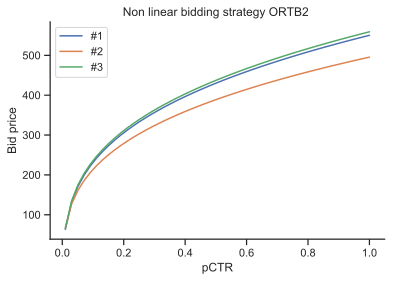

In [68]:
x = np.linspace(1e-2, 1)
y = ortb_strategy2(0.000090,90,x)
y2 = ortb_strategy2(0.000076,70,x)
y3 = ortb_strategy2(0.000086,90,x)

plt.plot(x,y, label='#1')
plt.plot(x, y2, label='#2')
plt.plot(x, y3, label='#3')
sns.despine()
plt.title('Non linear bidding strategy ORTB2 ')
plt.ylabel('Bid price')
plt.xlabel('pCTR')
plt.legend()
plt.show()

In [37]:
%%time
X_test = test.drop(columns=['click', 'payprice'])
y_test_prob = lr.predict_proba(X_test)

pCTR = y_test_prob[:, 1]

bids = ortb_strategy(0.000053, 55, pCTR)

# get bid id's
test_raw = pd.read_csv('../we_data/test.csv')

# export to file
df_bids = pd.DataFrame(
    np.round(bids, 1), index=test_raw['bidid'].values, columns=['bidprice'])
df_bids.index.name = 'bidid'
df_bids = df_bids.reset_index()

df_bids.to_csv('bid_attemnt_ortb.csv', index=False)

CPU times: user 12.1 s, sys: 8.87 s, total: 21 s
Wall time: 24.4 s


In [206]:
lr = pickle.load(open( "lr_model", "rb" ))

# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=1)
# %time lr.fit(X_train, y_train)

# performance
y_hat = lr.predict(X_test)

print(classification_report_imbalanced(y_test, y_hat, target_names=['no click', 'click']))
print("Balanced accuracy score: {:.3%}".format(balanced_accuracy_score(y_test, y_hat) ))
print('ROC AUC score {}'.format(roc_auc_score(y_test, y_hat)))
print('done')

                   pre       rec       spe        f1       geo       iba       sup

   no click       0.95      0.96      0.95      0.96      0.96      0.91     25071
      click       0.96      0.95      0.96      0.96      0.96      0.91     24891

avg / total       0.96      0.96      0.96      0.96      0.96      0.91     49962

Balanced accuracy score: 95.566%
ROC AUC score 0.9556594981954275
done
